In [24]:
path = r"C:\Users\schla\git\capo\results\subj\mistral\CAPO\seed42\benchmark_experiment_subj_mistral_CAPO_42\eac414135d4beaa2a3c24f16de77a4ba73ef222b9c99448e70552d4574f76b21\step_results.csv"
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv(path)
df

,step,timestamp,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,time_elapsed,score,prompt
0,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.762846,Linguistic analysis: Examine the provided sent...
1,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.732345,You are tasked with analyzing each sentence to...
2,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.720422,Task: Classify each sentence as either subject...
3,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.676153,Classify as objective (fact-based) or subjecti...
4,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.657312,Subjectivity analysis task: Examine the senten...
...,...,...,...,...,...,...,...,...,...
215,22,2025-03-13 18:28:36.638667,2085,1154,115851,39132,77.708483,0.697704,Task: Analyze the sentence to determine whethe...
216,22,2025-03-13 18:28:36.638667,2085,1154,115851,39132,77.708483,0.691850,Task: Classify each sentence as either subject...
217,22,2025-03-13 18:28:36.638667,2085,1154,115851,39132,77.708483,0.684237,Task: Analyze the sentence to determine whethe...
218,22,2025-03-13 18:28:36.638667,2085,1154,115851,39132,77.708483,0.658536,You are tasked with analyzing each sentence to...


In [25]:
df[df["step"] == 1]

,step,timestamp,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,time_elapsed,score,prompt
0,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.762846,Linguistic analysis: Examine the provided sent...
1,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.732345,You are tasked with analyzing each sentence to...
2,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.720422,Task: Classify each sentence as either subject...
3,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.676153,Classify as objective (fact-based) or subjecti...
4,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.657312,Subjectivity analysis task: Examine the senten...
5,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.640975,Sentence classification task: Does the sentenc...
6,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.637154,Determine whether each sentence is subjective ...
7,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.634519,Analyze the given sentence to determine whethe...
8,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.616667,Using your understanding of subjectivity vs. o...
9,1,2025-03-13 18:00:08.645871,1424,635,161831,29141,125.999972,0.605204,Read the following sentence and classify it as...


In [37]:
# group df by step and get the mean of the values (ignore stings)
df_grouped = df.groupby("step", as_index=False).mean(numeric_only=True)
df_grouped["cum_input_tokens"] = df_grouped["input_tokens_downstream_llm"].cumsum()

# join the maximum score for each step
df_grouped = df_grouped.join(
    df.groupby("step", as_index=False).max()[["step", "score"]].set_index("step"),
    on="step",
    rsuffix="_max",
)

df_grouped

,step,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,time_elapsed,score,cum_input_tokens,score_max
0,1,1424.0,635.0,161831.0,29141.0,125.999972,0.668360,161831.0,0.762846
1,2,1627.0,880.0,568037.0,140056.0,238.084428,0.650768,729868.0,0.691850
2,3,1814.0,955.0,100754.0,41299.0,60.767496,0.683149,830622.0,0.737846
3,4,1775.0,916.0,130451.0,43164.0,70.440861,0.668938,961073.0,0.716179
4,5,1701.0,911.0,160556.0,64794.0,96.849998,0.672012,1121629.0,0.714698
5,6,1670.0,852.0,20320.0,8610.0,14.442060,0.751271,1141949.0,0.796179
6,7,1833.0,1039.0,54166.0,18740.0,31.208828,0.751271,1196115.0,0.796179
7,8,1684.0,894.0,168342.0,87674.0,111.092516,0.664881,1364457.0,0.716179
8,9,1816.0,1005.0,104550.0,37804.0,73.218236,0.664881,1469007.0,0.716179
9,10,1736.0,850.0,55772.0,37234.0,46.204789,0.697994,1524779.0,0.746179


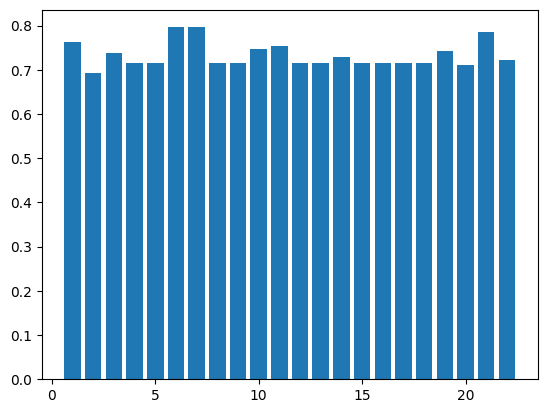

In [27]:
plt.bar(df_grouped["step"], df_grouped["score_max"]);

(0.6918501788067006, 0.7961791831357047)

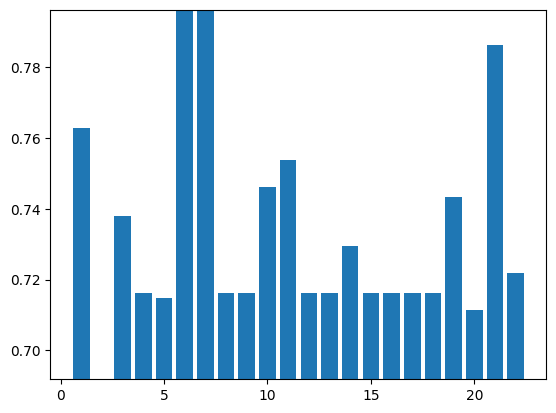

In [40]:
# plot token count vs step and adapt y-axis to min and max
column = "score_max"
plt.bar(df_grouped["step"], df_grouped[column])
plt.ylim(df_grouped[column].min(), df_grouped[column].max())

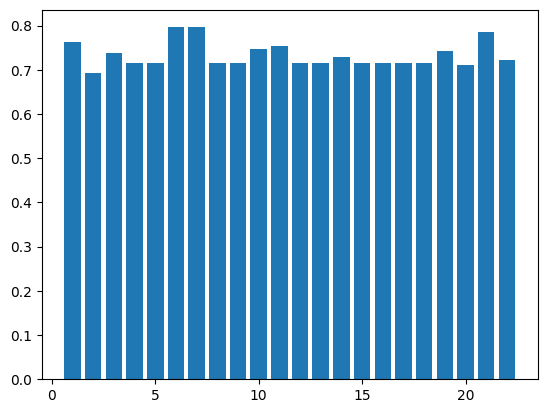

In [29]:
# group df by step and get the mean of the values (ignore stings)
df_grouped = df.groupby("step", as_index=False).max(numeric_only=True)
plt.bar(df_grouped["step"], df_grouped["score"]);

In [30]:
df_grouped

,step,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,time_elapsed,score
0,1,1424,635,161831,29141,125.999972,0.762846
1,2,1627,880,568037,140056,238.084428,0.691850
2,3,1814,955,100754,41299,60.767496,0.737846
3,4,1775,916,130451,43164,70.440861,0.716179
4,5,1701,911,160556,64794,96.849998,0.714698
5,6,1670,852,20320,8610,14.442060,0.796179
6,7,1833,1039,54166,18740,31.208828,0.796179
7,8,1684,894,168342,87674,111.092516,0.716179
8,9,1816,1005,104550,37804,73.218236,0.716179
9,10,1736,850,55772,37234,46.204789,0.746179


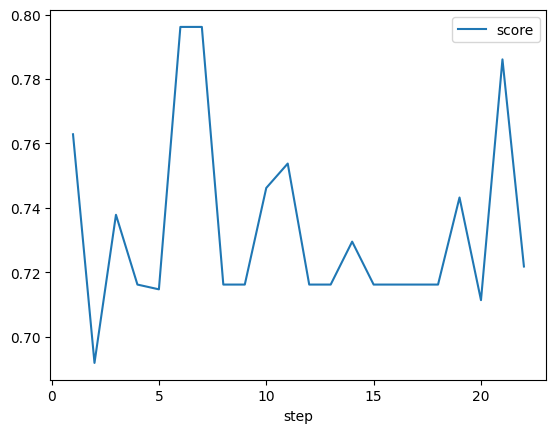

In [31]:
df_grouped.plot(x="step", y="score", kind="line");

In [32]:
df_counts = r"C:\Users\schla\git\capo\results\sst-5\llama\CAPO\seed44\benchmark_experiment_sst-5_llama_CAPO_44\cbc743c08d16c22ec7791bac5008d8c2381cb9c1cee4856ddc2f2fef761ef521\tra.csv"
df_counts = pd.read_csv(df_counts)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\schla\\git\\capo\\results\\sst-5\\llama\\CAPO\\seed44\\benchmark_experiment_sst-5_llama_CAPO_44\\cbc743c08d16c22ec7791bac5008d8c2381cb9c1cee4856ddc2f2fef761ef521\\tra.csv'

In [ ]:
df_counts.groupby("prompt").count()

,Unnamed: 0,block_id
prompt,,
"Analyze the sentiment expressed in this film critique. Categorize it as either veryNegative, negative, neutral, positive, or veryPositive, and present your answer between <final_answer> </final_answer> tags.\n\nInput: cold , pretentious , thoroughly dislikable study in sociopathy .\nOutput: <final_answer> negative </final_answer>\n\nInput: the work of an artist tormented by his heritage , using his storytelling ability to honor the many faceless victims .\nOutput: <final_answer> positive </final_answer>\n\n\nInput:",10,10
"Assess the emotional undertones in the given movie review and assign it to one of five distinct sentiment categories - veryNegative, negative, neutral, positive, or veryPositive - clearly demarcating your chosen classification with <final_answer> and </final_answer> to signify the review's overall sentiment.\n\nconforms itself with creating a game of ` who 's who ' ... where the characters ' moves are often more predictable than their consequences .\n<|start_header_id|>assistant<|end_header_id|>\n\nThe given review seems to imply that the movie is somewhat lacking in originality and unpredictability, as it creates a game of ""who's who"" with predictable character moves. This suggests a slightly negative tone. However, the criticism is not overly harsh, and there's no strong language used to condemn the movie outright. Therefore, the sentiment can be classified as negative, but not very negative, as it doesn't express extreme dissatisfaction.\n\n<final_answer> negative </final_answer>\n\nInput: what 's hard to understand is why anybody picked it up .\nOutput: <final_answer> veryNegative </final_answer>\n\n\nInput:",1,1
"Assess the sentiment expressed in the given movie review and categorize it into one of five emotional tone categories: veryNegative, negative, neutral, positive, or veryPositive, ensuring your selected category is enclosed between the <final_answer> and </final_answer> tags for identification.\n\nInput: an almost unbearably morbid love story .\nOutput: <final_answer> veryNegative </final_answer>\n\nInput: not completely loveable -- but what underdog movie since the bad news bears has been ?\nOutput: <final_answer> negative </final_answer>\n\nInput: a comedy-drama of nearly epic proportions rooted in a sincere performance by the title character undergoing midlife crisis .\nOutput: <final_answer> veryPositive </final_answer>\n\n\nInput:",10,10
"Assess the sentiment expressed in the given movie review and categorize it into one of five emotional tone categories: veryNegative, negative, neutral, positive, or veryPositive, ensuring your selected category is enclosed within <final_answer> and </final_answer> tags for clear identification.\n\nInput: the film does n't have enough innovation or pizazz to attract teenagers , and it lacks the novel charm that made spy kids a surprising winner with both adults and younger audiences .\nOutput: <final_answer> veryNegative </final_answer>\n\nInput: not completely loveable -- but what underdog movie since the bad news bears has been ?\nOutput: <final_answer> negative </final_answer>\n\n\nInput:",4,4
"Assess the sentiment of a given movie review, determining whether it expresses a veryNegative, negative, neutral, positive, or veryPositive opinion, and encapsulate your assessment within <final_answer> and </final_answer> tags to denote the review's emotional tone.\n\nInput: it 's packed to bursting with incident , and with scores of characters , some fictional , some from history .\nOutput: <final_answer> neutral </final_answer>\n\nit has its faults , but it is a kind , unapologetic , sweetheart of a movie , and mandy moore leaves a positive impression .\n<|start_header_id|>assistant<|end_header_id|>\n\n<final_answer>positive</final_answer>\n\n\nInput:",10,10
"Assess the sentiment of a movie review by determining the emotional tone conveyed and assign it to one of five categories: veryNegative, negative, neutral, positive, or ver

In [ ]:
Evaluate the emotional tone of the given movie review and assign it to one of five sentiment categories: veryNegative, negative, neutral, positive, or veryPositive, then encapsulate your chosen category within the <final_answer> answer </final_answer> tags to facilitate a straightforward assessment of the review's sentiment and its evoked emotional response.

conforms itself with creating a game of ` who 's who ' ... where the characters ' moves are often more predictable than their consequences .
<|start_header_id|>assistant<|end_header_id|>

The given movie review seems to convey a sense of predictability and lack of surprise, which might indicate a slightly negative tone. The phrase "more predictable than their consequences" suggests that the reviewer found the plot or character actions to be somewhat expected, which could detract from the overall viewing experience. However, the tone does not seem to be extremely harsh or critical. Therefore, the sentiment category that best fits this review is "negative".

<final_answer> negative </final_answer>

Input: it 's packed to bursting with incident , and with scores of characters , some fictional , some from history .
Output: <final_answer> neutral </final_answer>

Input: i loved this film .
Output: <final_answer> veryPositive </final_answer>


Input: 